In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import geoplot as gplt
import geopandas as gpd
import pylas
import gc
from shapely.geometry import Point
import pandas as pd
import utm
import zipfile
from matplotlib.colors import LogNorm, TwoSlopeNorm

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

In [2]:
neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')

Extent: (-90.14003111, 29.86560481, -89.87, 30.08)


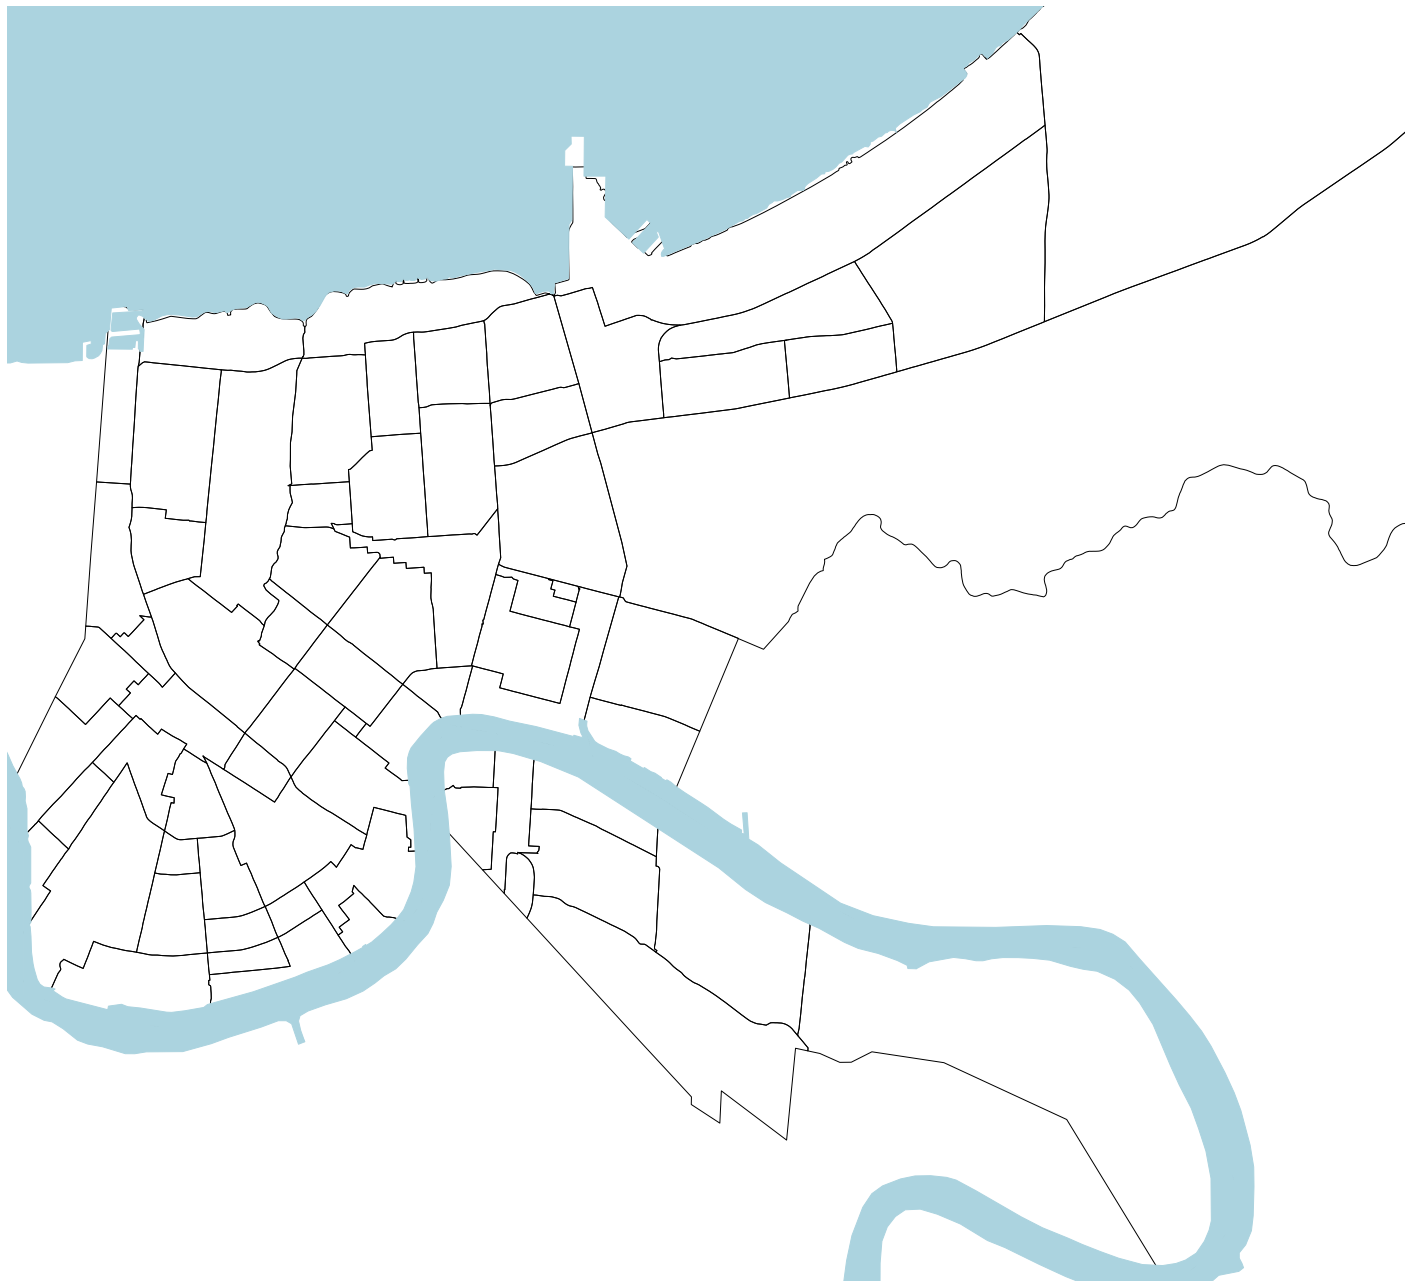

In [3]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)

gplt.polyplot(neighborhoodDf, edgecolor='black', projection=projection, ax=ax, extent=extent)
gplt.polyplot(waterDf,ax=ax, \
                zorder=11, projection=projection, extent=extent, edgecolor='#abd3df', facecolor='#abd3df')
   

fig.tight_layout()

print("Extent:", extent)

In [4]:
xmlFiles = pd.read_pickle('./xmlFilesGeo.pickle')

#only load overlapped
xmlFiles = xmlFiles[xmlFiles['overLap']]

fileNames = [(x,x.replace('.zip','.las')) for x in [x.split('/')[-1] for x in xmlFiles['ftpFileName'].to_list()]]

del xmlFiles
print("File count: ", len(fileNames))

File count:  292


In [5]:
#probability of point being choosen
desiredPointsPerTile = 500

class LoadFileException(Exception):
    pass

def loadFile(fileName):
    
    with zipfile.ZipFile(lasPath + fileName[0]) as f:
        rawData = f.read(fileName[1])
        lasData = pylas.read(rawData)
    
    del rawData
    
    ground = lasData.classification == 2
    pointCount = np.count_nonzero(ground)
    
    #include low vegitation if not enough ground points
    if pointCount < desiredPointsPerTile:
        ground = ground | (lasData.classification == 3) 
    
    if  pointCount == 0:
        raise(LoadFileException('No ground/lowveg points in this dataset'))
    
    X = lasData.x[ground]
    Y = lasData.y[ground]
    Z = lasData.z[ground]
    if X.shape[0] <= desiredPointsPerTile:
        randSample = np.repeat(np.True_, X.shape[0])
    else:
        pointProb = desiredPointsPerTile / float(X.shape[0])
        randSample = np.random.choice([np.True_,np.False_], X.shape[0], p=[pointProb,1-pointProb])
    
    X = X[randSample]
    Y = Y[randSample]
    Z = Z[randSample]
    
    df = gpd.GeoDataFrame(Z, geometry=gpd.points_from_xy(X,Y), columns=['elevation']).set_crs(32215).to_crs(epsg)
    
    return df

In [6]:
fullFileName = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755120_LAS_2018.zip'
fileName = fullFileName.split('/')[-1]
lasDf = loadFile((fileName, fileName.replace('.zip','.las')))
lasDf.head()

,elevation,geometry
0,1.56,POINT (-90.14544 29.92020)
1,4.01,POINT (-90.14492 29.92018)
2,2.11,POINT (-90.14631 29.92037)
3,1.66,POINT (-90.14500 29.92095)
4,1.96,POINT (-90.14579 29.92115)


In [7]:
%%time
dfs = []
for fileName in fileNames:
    try:
        dfs.append(loadFile(fileName))
    except LoadFileException as e:
        print("\n%s failed: %s" % (fileName[0],str(e)))
    
    
    print('.', end='')
    gc.collect()

print("Processed files: ", len(dfs))
lasDf = pd.concat(dfs)
print("Points Processed: ", len(lasDf))

..............
USGS_LPC_LA_UpperDeltaPlain_2017_15rzp040345_LAS_2018.zip failed: No ground/lowveg points in this dataset
.........................................................
USGS_LPC_LA_UpperDeltaPlain_2017_15rzp055345_LAS_2018.zip failed: No ground/lowveg points in this dataset
................
USGS_LPC_LA_UpperDeltaPlain_2017_15rzp070345_LAS_2018.zip failed: No ground/lowveg points in this dataset
.............................
USGS_LPC_LA_UpperDeltaPlain_2017_15ryp860285_LAS_2018.zip failed: No ground/lowveg points in this dataset
...............................
USGS_LPC_LA_UpperDeltaPlain_2017_15rzp100375_LAS_2018.zip failed: No ground/lowveg points in this dataset
...............................................................
USGS_LPC_LA_UpperDeltaPlain_2017_15ryp845285_LAS_2018.zip failed: No ground/lowveg points in this dataset
.....................
USGS_LPC_LA_UpperDeltaPlain_2017_15ryp845270_LAS_2018.zip failed: No ground/lowveg points in this dataset
....................

In [8]:
lasDf.head()

,elevation,geometry
0,-1.54,POINT (-89.89340 30.05003)
1,-0.60,POINT (-89.89384 30.05069)
2,-1.20,POINT (-89.89287 30.04964)
3,-0.08,POINT (-89.89267 30.04984)
4,-0.87,POINT (-89.89265 30.05066)


In [9]:
lasDf['elevationFeet'] = lasDf['elevation'] * 3.28084
twoSlopNorm = TwoSlopeNorm(0)

lasDf['aboveSeaLevel'] = 1 * (lasDf['elevation'] > 0.0)

lasDf['twoSlopElevationFeet'] = twoSlopNorm(lasDf['elevationFeet'])
lasDf.head()

,elevation,geometry,elevationFeet,aboveSeaLevel,twoSlopElevationFeet
0,-1.54,POINT (-89.89340 30.05003),-5.052494,0,0.395522
1,-0.60,POINT (-89.89384 30.05069),-1.968504,0,0.459294
2,-1.20,POINT (-89.89287 30.04964),-3.937008,0,0.418589
3,-0.08,POINT (-89.89267 30.04984),-0.262467,0,0.494573
4,-0.87,POINT (-89.89265 30.05066),-2.854331,0,0.440977


Extent: (-90.14003111, 29.86560481, -89.87, 30.08)


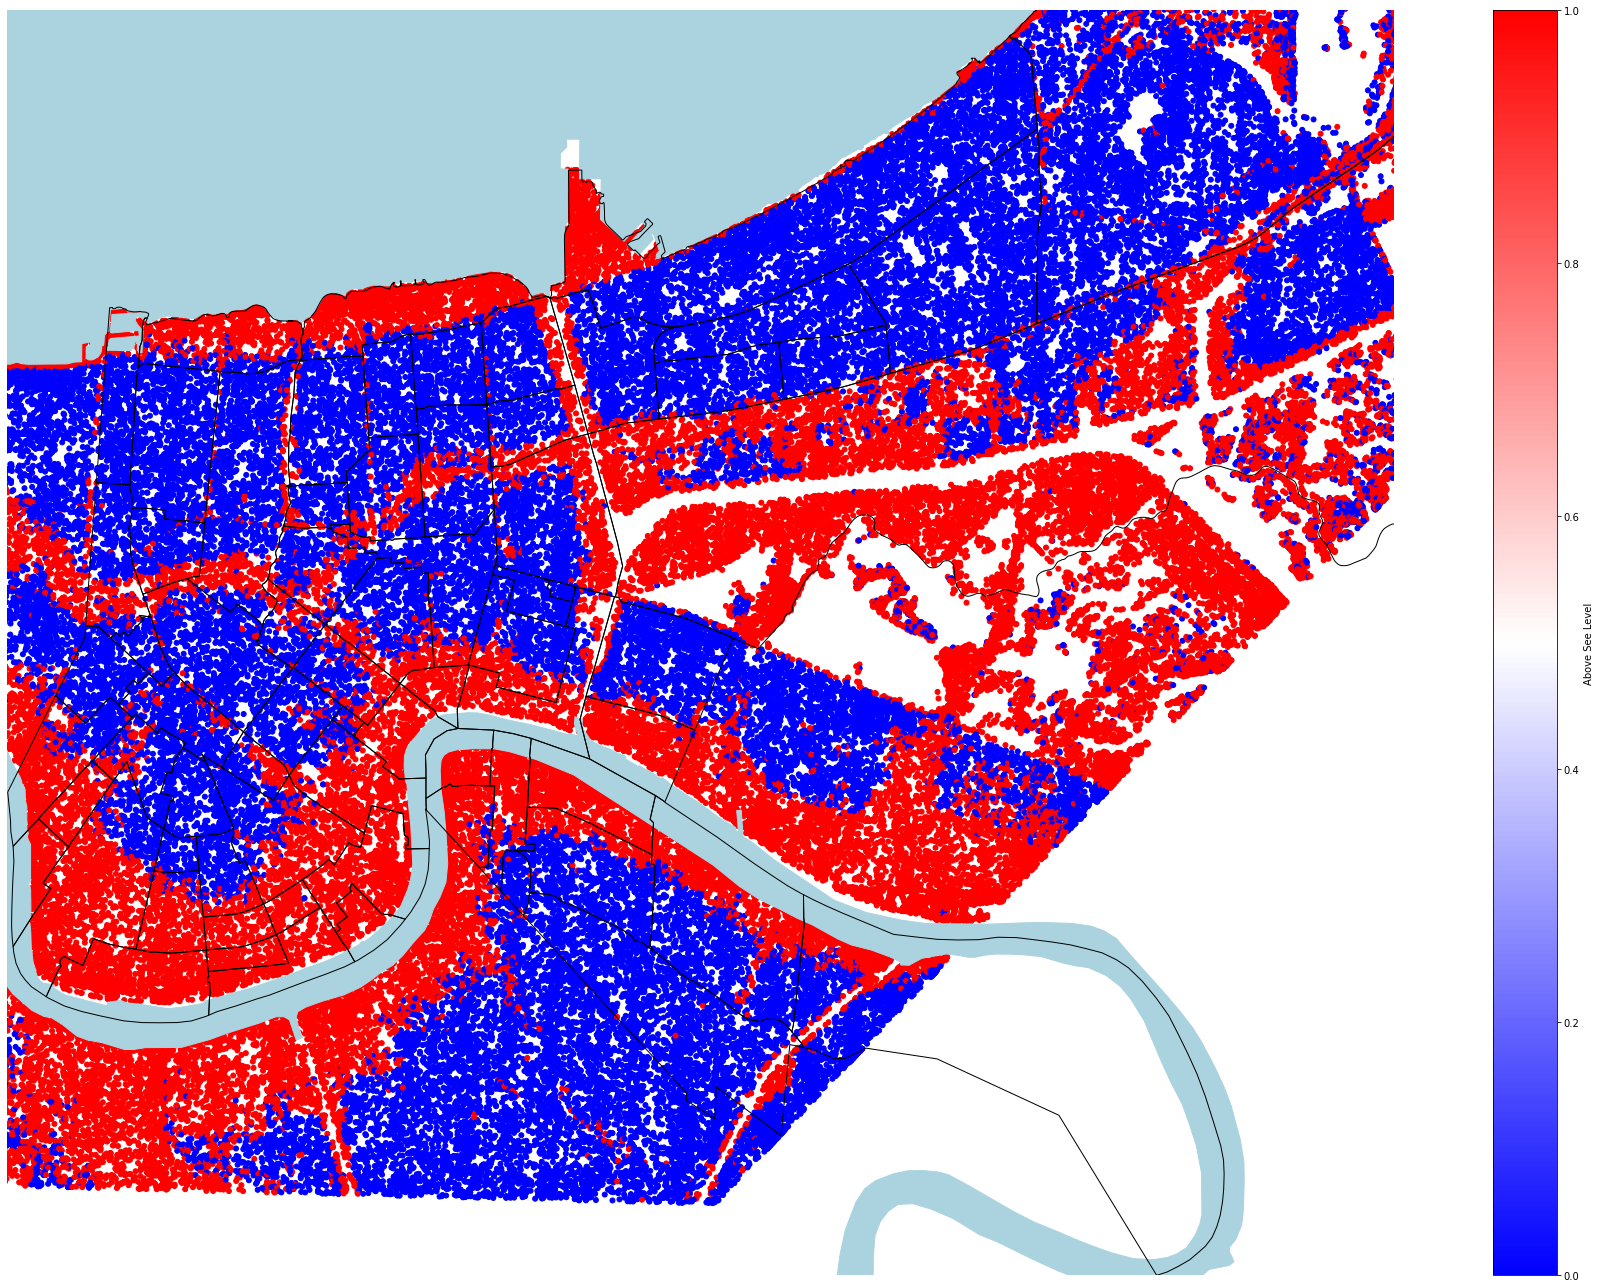

In [13]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)


gplt.pointplot(lasDf,hue='aboveSeaLevel', legend=True, ax=ax, projection=projection, zorder=20, extent=extent, cmap='bwr')
gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=23)

cbar = fig.get_axes()[-1]
#cbar.set_yticklabels(['Above' if x > 0.5 else 'below' for x in twoSlopNorm.inverse(cbar.get_yticks())])
cbar.set_ylabel('Above See Level == 1') 


fig.tight_layout()

print("Extent:", extent)

In [11]:
lasDf.count()

elevation               141313
geometry                141313
elevationFeet           141313
aboveSeaLevel           141313
twoSlopElevationFeet    141313
dtype: int64

In [12]:
lasDf.count()

elevation               141313
geometry                141313
elevationFeet           141313
aboveSeaLevel           141313
twoSlopElevationFeet    141313
dtype: int64